In [2]:
# Imports and setup

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths & settings
TRAIN_DIR = './data/HAM10000_images/train_dir'
VAL_DIR = './data/HAM10000_images/val_dir'
MODEL_SAVE_PATH = './models/skin_lesion_model.keras'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

os.makedirs('./models', exist_ok=True)
os.makedirs('./plots', exist_ok=True)

# Classes
class_names = sorted(os.listdir(TRAIN_DIR))
print(f"Classes found: {class_names}")

Classes found: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [6]:
# Dataset structure visualization

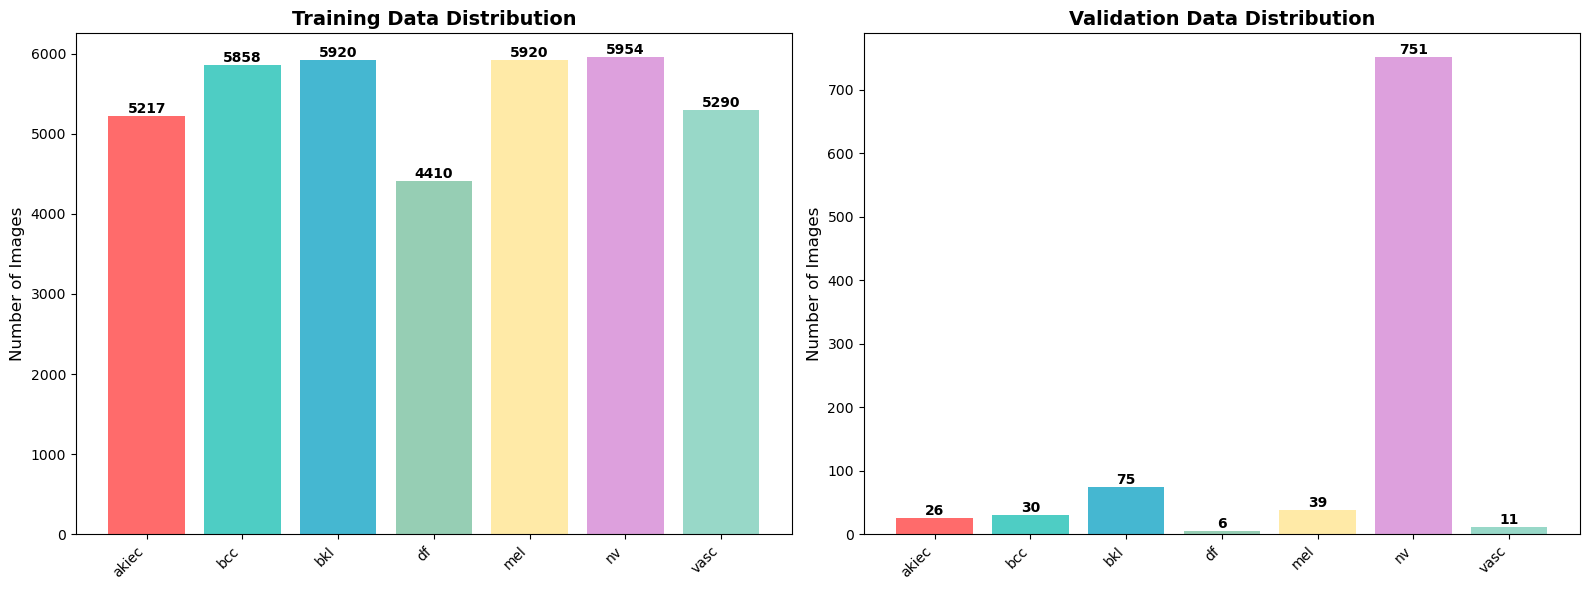

In [8]:
def analyze_dataset(train_dir, val_dir, class_names):
    train_counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in class_names}
    val_counts = {c: len(os.listdir(os.path.join(val_dir, c))) for c in class_names}

    # Plot distribution
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']

    # Training
    bars1 = ax1.bar(train_counts.keys(), train_counts.values(), color=colors)
    ax1.set_title('Training Data Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Images', fontsize=12)
    ax1.set_xticklabels(train_counts.keys(), rotation=45, ha='right')
    
    # Validation
    bars2 = ax2.bar(val_counts.keys(), val_counts.values(), color=colors)
    ax2.set_title('Validation Data Distribution', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Images', fontsize=12)
    ax2.set_xticklabels(val_counts.keys(), rotation=45, ha='right')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax = bar.axes
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('./plots/dataset_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return train_counts, val_counts

train_counts, val_counts = analyze_dataset(TRAIN_DIR, VAL_DIR, class_names)

In [9]:
# Sample images visualization

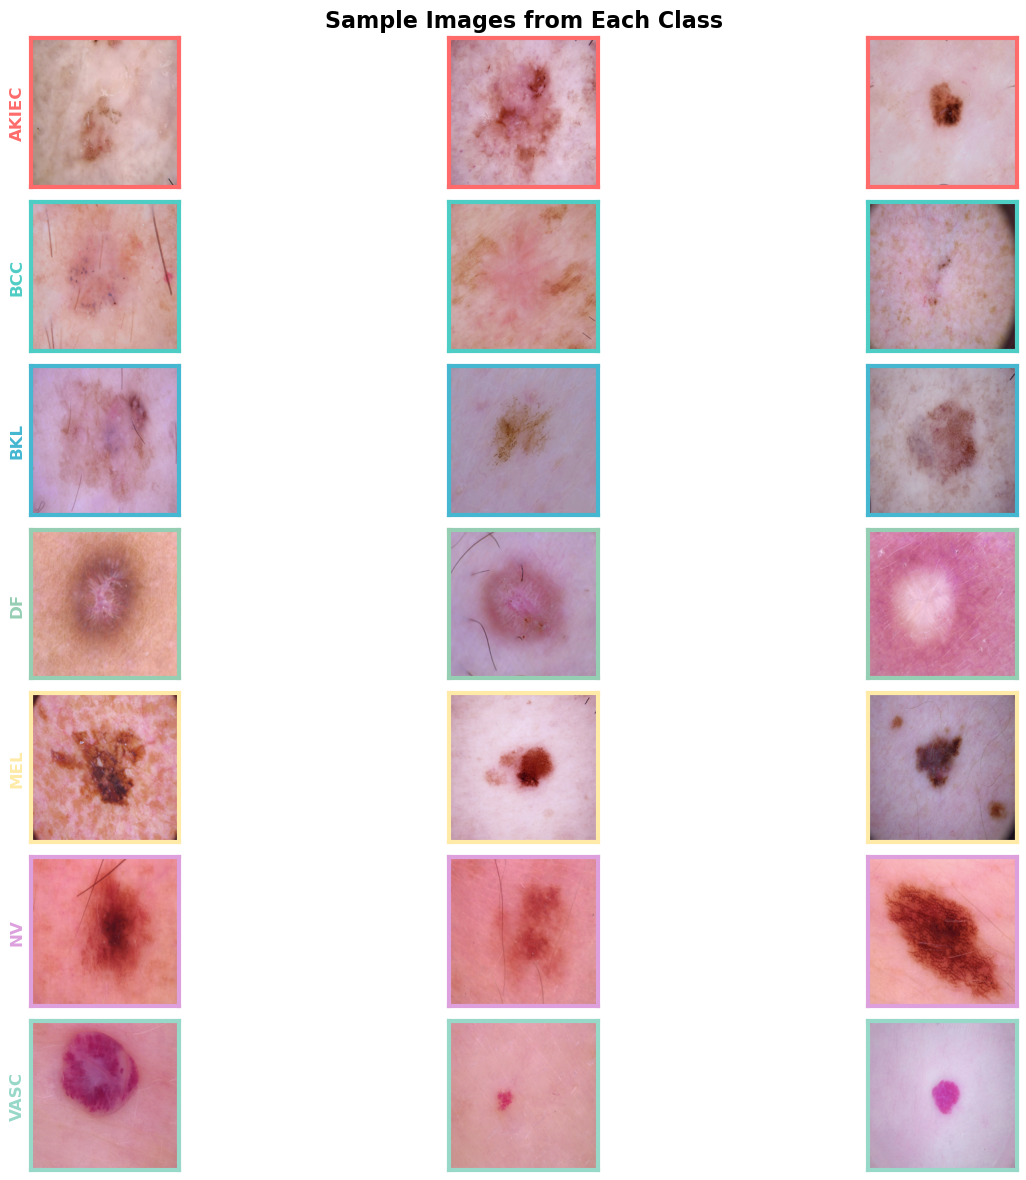

In [10]:
def display_sample_images(data_dir, class_names, num_samples=3):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 12))
    fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)[:num_samples]
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).resize(IMG_SIZE)
            axes[i, j].imshow(img)
            if j == 0:
                axes[i, j].set_ylabel(class_name.upper(), fontsize=12, fontweight='bold', color=colors[i])
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            for spine in axes[i, j].spines.values():
                spine.set_color(colors[i])
                spine.set_linewidth(3)
    plt.tight_layout()
    plt.savefig('./plots/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

display_sample_images(TRAIN_DIR, class_names)

In [11]:
# Create data generators

In [14]:
def create_generators(train_dir, val_dir, img_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        brightness_range=[0.7,1.3],
        channel_shift_range=0.2
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=SEED
    )
    return train_gen, val_gen

train_gen, val_gen = create_generators(TRAIN_DIR, VAL_DIR, IMG_SIZE, BATCH_SIZE)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [15]:
# Compute Class Weights

In [16]:
all_labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(zip(range(len(class_names)), class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0561351625181412, 1: 0.9405696727308199, 2: 0.930719111969112, 3: 1.2494007126660187, 4: 0.930719111969112, 5: 0.925404290033111, 6: 1.0415608965703484}


In [17]:
# Model Definition

In [18]:
def create_model(num_classes=len(class_names), input_shape=(224,224,3)):
    input_layer = layers.Input(shape=input_shape)
    
    effnet = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)
    for layer in effnet.layers[:150]:
        layer.trainable = False
    effnet_features = layers.GlobalAveragePooling2D()(effnet.output)
    
    densenet = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)
    for layer in densenet.layers[:150]:
        layer.trainable = False
    densenet_features = layers.GlobalAveragePooling2D()(densenet.output)
    
    x = layers.concatenate([effnet_features, densenet_features])
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=input_layer, outputs=outputs)
    return model

model = create_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 12,270,826 (46.81 MB)

 Trainable params: 9,924,703 (37.86 MB)

 Non-trainable params: 2,346,123 (8.95 MB)

In [19]:
# Training

In [20]:
steps_per_epoch = train_gen.samples // train_gen.batch_size
val_steps = val_gen.samples // val_gen.batch_size

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1),
    CSVLogger('./models/history.csv')
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    steps_per_epoch=200,
    validation_steps=val_steps,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3621 - loss: 1.6937
Epoch 1: val_accuracy improved from -inf to 0.83297, saving model to ./models/skin_lesion_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 870s 4s/step - accuracy: 0.3627 - loss: 1.6923 - val_accuracy: 0.8330 - val_loss: 0.5066 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5963 - loss: 1.0732
Epoch 2: val_accuracy improved from 0.83297 to 0.85560, saving model to ./models/skin_lesion_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - accuracy: 0.5964 - loss: 1.0730 - val_accuracy: 0.8556 - val_loss: 0.4674 - learning_rate: 1.0000e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6541 - loss: 0.9443
Epoch 3: val_accuracy improved from 0.85560 to 0.85991, saving model to ./models/skin_lesion_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 708s 4s/step - accuracy: 0.6542 - loss: 0.9441 - val_accuracy: 0.8599 - val_loss: 0.4188 - learning_rate: 1.0000

In [38]:
# Plot Training & Validation Accuracy

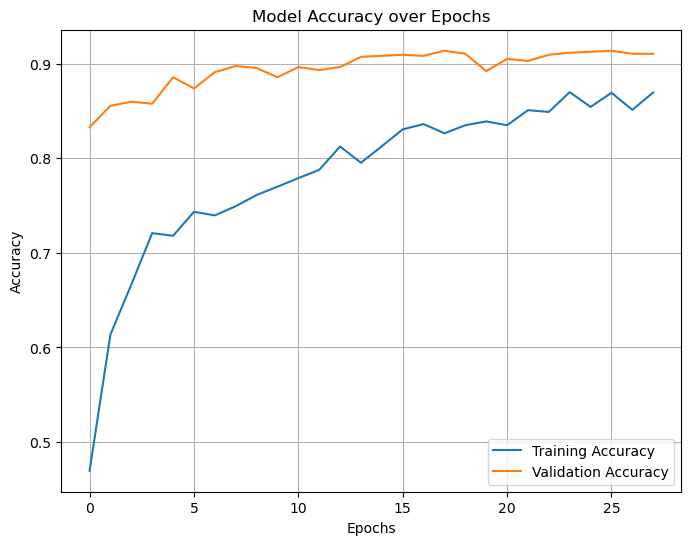

In [40]:
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Plot Training & Validation Loss

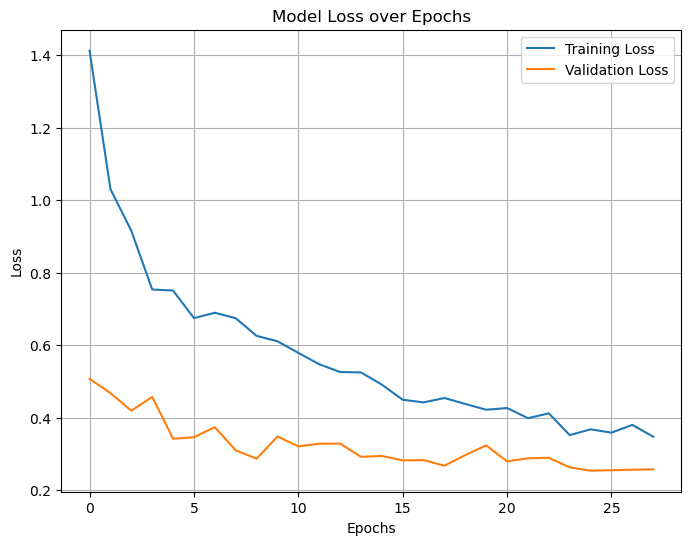

In [44]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Always save final model at the end (even if not the best one)

In [32]:
FINAL_MODEL_PATH = './models/skin_lesion_model_final.keras'
model.save(FINAL_MODEL_PATH)
print(f"Final model saved to {FINAL_MODEL_PATH}")

Final model saved to ./models/skin_lesion_model_final.keras


In [23]:
# Evaluation

59/59 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step


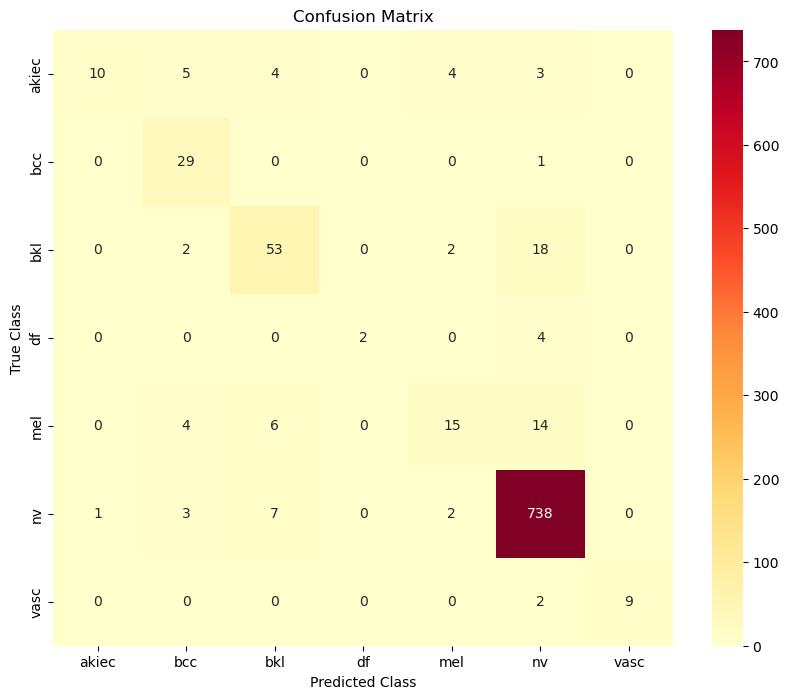

              precision    recall  f1-score   support

       akiec     0.9091    0.3846    0.5405        26
         bcc     0.6744    0.9667    0.7945        30
         bkl     0.7571    0.7067    0.7310        75
          df     1.0000    0.3333    0.5000         6
         mel     0.6522    0.3846    0.4839        39
          nv     0.9462    0.9827    0.9641       751
        vasc     1.0000    0.8182    0.9000        11

    accuracy                         0.9126       938
   macro avg     0.8484    0.6538    0.7020       938
weighted avg     0.9101    0.9126    0.9046       938



In [24]:
best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
val_gen.reset()
y_pred = best_model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='YlOrRd')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

In [46]:
# Prediction Function
def predict_skin_lesion(image_path, model=best_model):
    img = Image.open(image_path).resize(IMG_SIZE)
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    preds = model.predict(img_array)
    pred_class = np.argmax(preds[0])
    pred_prob